In [21]:
import os, random
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams["xtick.direction"] = 'in'
plt.rcParams["ytick.direction"] = 'in'
params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 14,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16,
   'text.usetex': False,
   'figure.figsize': [6, 5],
   'mathtext.fontset': 'stix',
   'font.family': 'STIXGeneral'
   }
plt.rcParams.update(params)
from tqdm import tqdm
from load_data import load_Stanford_data
from model.degradation_model import Degradation_Transformer
from utils import find_nearest
from torchinfo import summary

CELL_IDS = ['G1', 'V5', 'W4', 'W5', 'W8', 'W9', 'V4', 'W10']

### Load model and data

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

stanford_data = load_Stanford_data('Stanford_Dataset/detrended_VI', mode='all', full=True)

# mean and standard deviation of voltage and current
m, s = [0, -0.55], [0.033, 1.1] 

# normalize
for d in stanford_data: 
    for i in range(2): 
        d[:, :, i] = (d[:, :, i]-m[i])/s[i]

# load model
model = Degradation_Transformer(in_dim=2,
                                d_model=128, 
                                ffn_hidden=512, 
                                n_head=2, 
                                n_layers=4, 
                                drop_prob=0.1).to(device)

model.load_state_dict(torch.load('checkpoints/DSSL_c128_d4.pth'))
model.eval()
summary(model,input_size=(2, 20, 2, 3600))

load cell (all): 100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Layer (type:depth-idx)                        Output Shape              Param #
Degradation_Transformer                       [2, 20, 1]                --
├─CNNEmbeddingLayer: 1-1                      [2, 20, 128]              --
│    └─Sequential: 2-1                        [40, 32, 3600]            --
│    │    └─Conv1d: 3-1                       [40, 32, 3600]            352
│    │    └─ReLU: 3-2                         [40, 32, 3600]            --
│    └─Sequential: 2-2                        [40, 32, 3600]            --
│    │    └─Conv1d: 3-3                       [40, 32, 3600]            5,152
│    │    └─ReLU: 3-4                         [40, 32, 3600]            --
│    └─Sequential: 2-3                        [40, 32, 3600]            --
│    │    └─Conv1d: 3-5                       [40, 32, 3600]            5,152
│    │    └─ReLU: 3-6                         [40, 32, 3600]            --
│    └─Sequential: 2-4                        [40, 32, 3600]            --
│    │    └─C

### Plot results

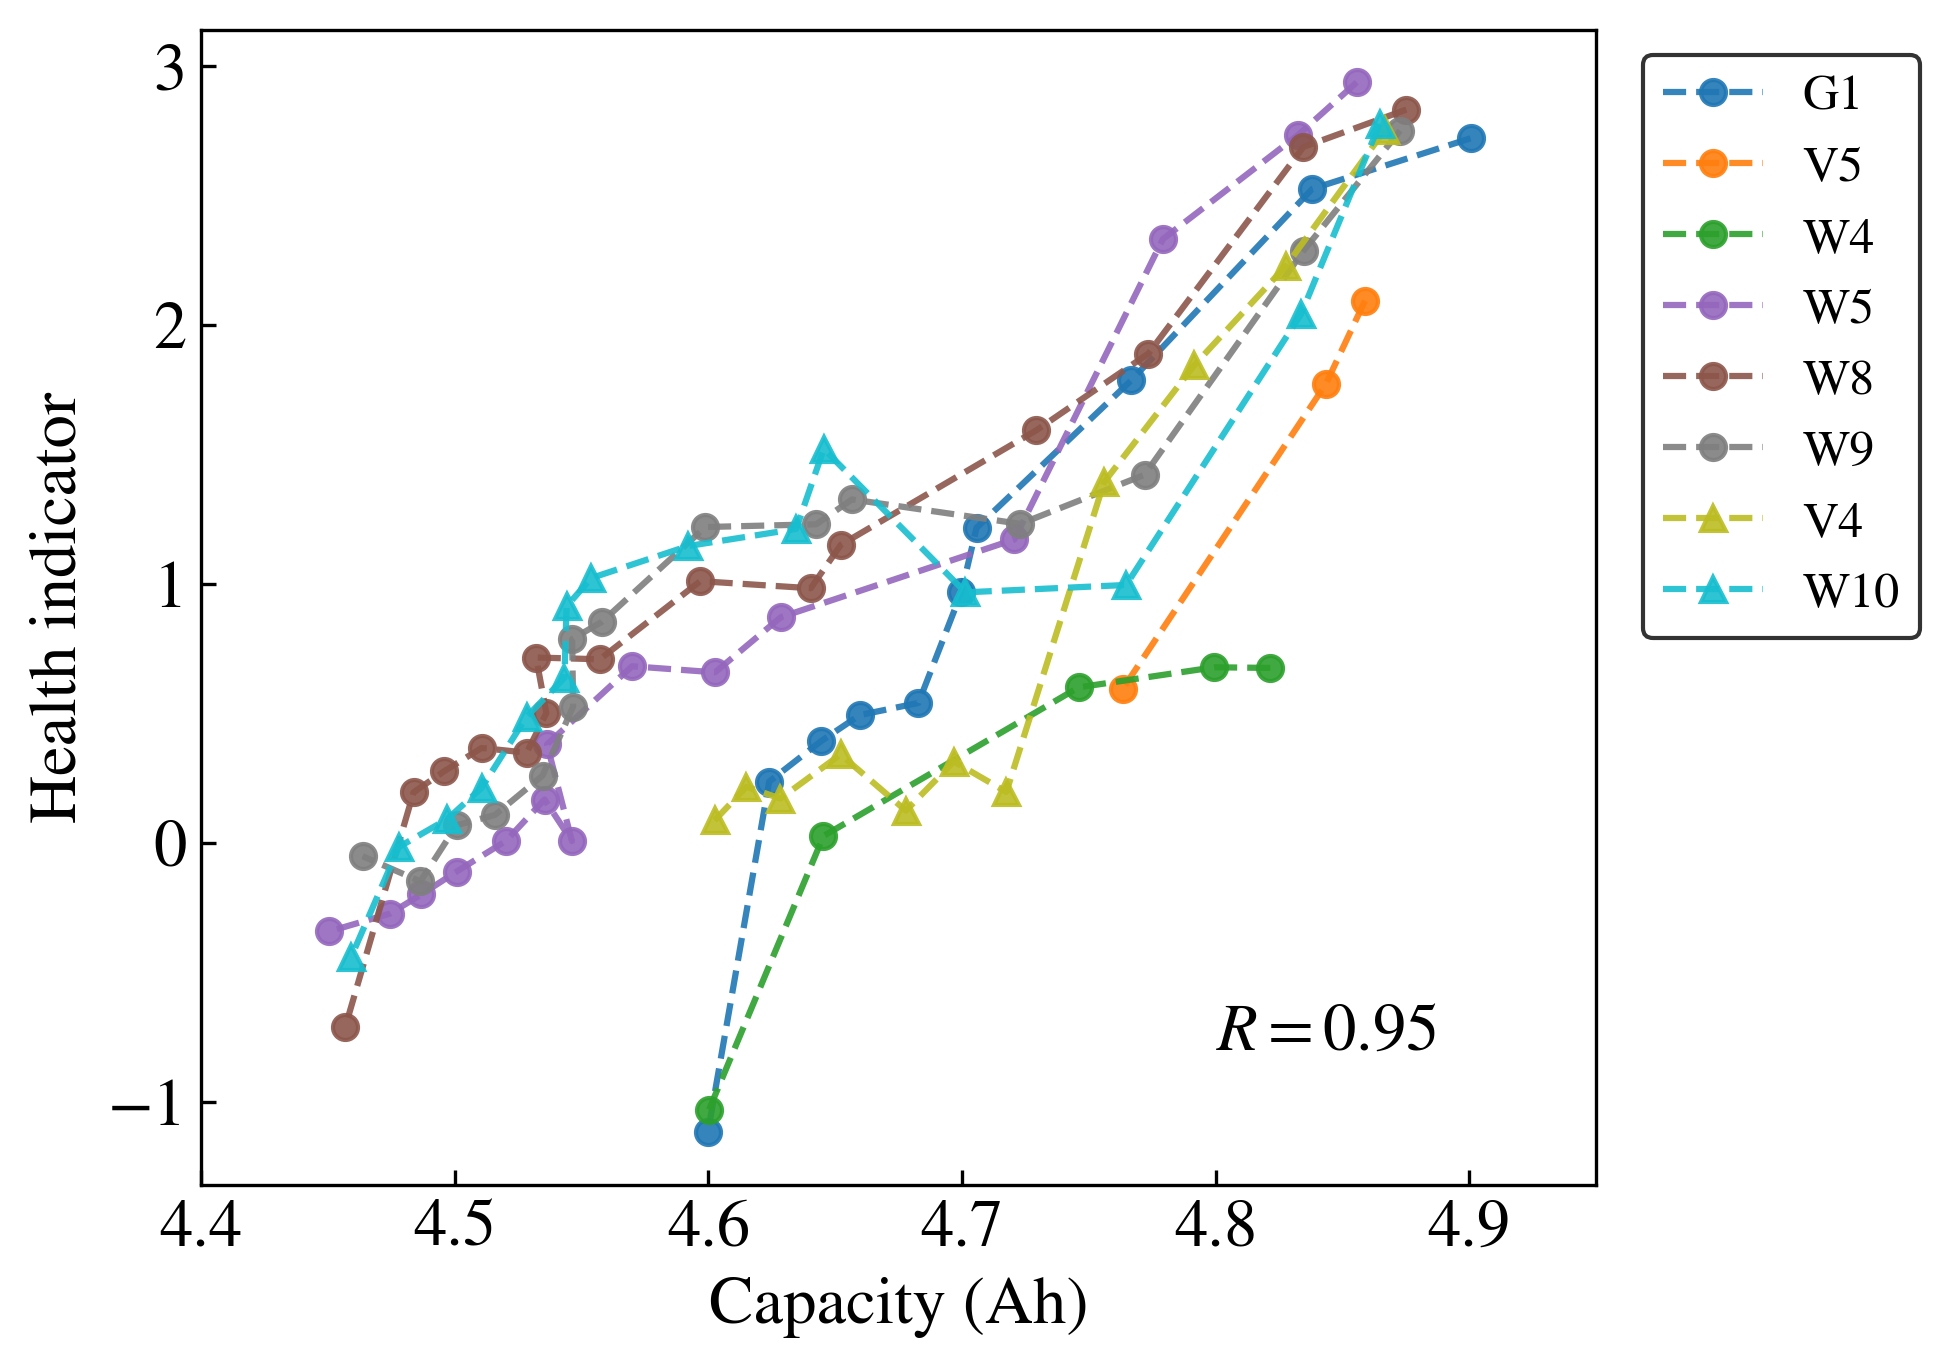

In [22]:
r = 0  # correlation coefficient
cm = plt.colormaps['tab10']

# plot training set data
for i, d in enumerate(stanford_data):
    cell_id = CELL_IDS[i]
    cycle_id = os.listdir('Stanford_Dataset/detrended_VI/%s'%cell_id)
    cycle_id = np.sort(np.array([int(f[-7:-4].lstrip('0')) for f in cycle_id]))
    cap_test = np.load(f'Stanford_Dataset/capacity_each_cell/{cell_id}_capacity.npy')
    pos = find_nearest(cycle_id, cap_test[0, :])
    soh = cap_test[1, :]
    with torch.no_grad():   
        inputs = d.reshape(-1, 20, 2, 3600)
        input_seq = torch.from_numpy(np.expand_dims(inputs[pos, 0, :, :], axis=0))
        health = model(input_seq.to(device).float()).detach().cpu().squeeze().numpy()

    soh_interp = np.interp(cycle_id[pos], cap_test[0, :], soh)
    marker = 'o' if i < 6 else '^'
    plt.plot(soh_interp, health, color=cm(i/7), marker=marker, alpha=.9, label=cell_id, markersize=6, ls='--')
    r += np.corrcoef(soh_interp, health)[0, 1]

plt.xlabel('Capacity (Ah)')
plt.ylabel('Health indicator')
plt.xlim([4.4, 4.95])
plt.text(4.8, -0.8, '$R=%.2f$'%(r/8))
frame = plt.legend(fontsize=12, bbox_to_anchor=(1.25, 1)).get_frame()
frame.set_edgecolor('0')
plt.show()
plt.close()